<a href="https://colab.research.google.com/github/sagiri262/DataMining-2025Fall-MUST/blob/main/Assignment_3_2250016066.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Similar document searching via MinHash and Locality Sensitive Hashing
This Jupyter Notebook organizes the experiment task of "Similar Document Retrieval based on MinHash and LSH", presenting text descriptions (Text) and code frameworks (Code) separately without modifying the original content.

## 1. Experiment Overview (Text)
In this project, we will implement the similar document retrieval system described in the lecture notes. This project is inspired by [http://mccormickml.com/2015/06/12/minhash-tutorial-with-python-code/](http://mccormickml.com/2015/06/12/minhash-tutorial-with-python-code/) (Note: You can refer to the code ideas on this website, but you need to implement it yourself).

### 1.1 Task Objective (Text)
We will use documents from this repository: [http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/assessment3.html](http://www.inf.ed.ac.uk/teaching/courses/tts/assessed/assessment3.html).
This dataset contains 10,000 documents, and some of the document pairs are marked as plagiarism instances. The goal of this experiment is to verify whether the MinHash and LSH system can identify these plagiarism instances efficiently and accurately.

Note: Smaller subsets of data suitable for testing can be obtained here: [https://github.com/chrisjmccormick/MinHash/tree/master/data](https://github.com/chrisjmccormick/MinHash/tree/master/data)

## 2. Part I: Preliminaries
**DUE**: Monday Sept. 10

### 2.1 Part IA: Dataset parsing (Text)
Write a function `parse_data` that takes the path to a filename, reads in the article data and returns an array of tuples. Requirements are as follows:
- One tuple per article (there is one article per line).
- Each tuple contains `(id, string)`, where `id` is the article id and `string` is the processed article text.
- Article text processing rules:
  1. Remove all punctuation.
  2. Change all letters to lowercase.
  3. Remove all whitespace so that all words are concatenated.

In [2]:
def parse_data(filename):
  import string
  from typing import List, Tuple
  # read lines from filename
  # construct tuple of id and text
  # process string as described above
  # return tuple with id and processed string
  data_list: List[Tuple[str, str]] = []

  translator = str.maketrans('', '', string.punctuation)

  try:
    with open(filename, 'r', encoding='utf-8') as f:
      for line in f:
        line = line.strip()
        if not line:
          # 跳过空行
          continue

        parts = line.split(maxsplit=1)
        if not parts:
          continue
        article_id = parts[0]
        raw_text = parts[1]

        # 全部转为小写字母
        processed_text = raw_text.lower()

        # 去除标点符号
        processed_text = raw_text.translate(translator)

        # 3. 移除所有空格（包括单词间的空格、换行符等）
        # ' ''.join(processed_text.split())' 可以保留一个空格，
        # 但根据要求 "Remove all whitespace so that all words are concatenated"，应移除所有空格
        processed_text = processed_text.replace(' ', '')
        processed_text = processed_text.replace('\t', '')
        processed_text = processed_text.replace('\n', '')

        data_list.append((article_id, processed_text))

  except FileNotFoundError:
    print(f"文件 '{filename}' 不存在。")
  except Exception as e:
    print(f"发生错误：{e}")

  return data_list



### 2.2 Part IB: Document shingles (Text)
Write a function `shingle_document` that takes a processed article string and a parameter `k` and shards the document as follows:
- Each substring of length $k$ in the document is hashed to a 32-bit integer (refer to the `crc32` function in Python's `binascii` library: [https://docs.python.org/3/library/binascii.html](https://docs.python.org/3/library/binascii.html)).
- Return a list of the unique 32-bit integers obtained in the previous step (use Python sets for deduplication).

In [3]:
def shingle_document(string, k):
  # initialize set data structure
  # for each position in string,
    # extract substring of length k
    # hash substring into 32-bit integer using crc32
    # insert into set
  # return set
  import binascii
  from typing import Set, List

  shingle_hashes = set()

  # 遍历字符串以提取所有长度为 k 的子字符串（Shingle）
  # 循环范围从 0 到 len(string) - k
  for i in range(len(string) - k + 1):
      # 1. 提取 Shingle
      shingle = string[i:i + k]

      # 2. 将 Shingle 编码为字节串 (bytes)，因为 crc32 期望字节输入
      shingle_bytes = shingle.encode('utf-8')

      # 3. 计算 CRC-32 哈希值，并将其添加到集合中进行去重
      # crc32 返回一个非负整数
      hash_value = binascii.crc32(shingle_bytes)
      shingle_hashes.add(hash_value)

  # 4. 返回包含唯一哈希值的列表
  return list(shingle_hashes)

### 2.3 Part IC: Jaccard Similarity (Text)
Write a function `jaccard` that takes two sharded documents and computes their Jaccard distance.

In [4]:
def jaccard(a, b):
  # compute union size
  # compute intersection size
  # return ratio of union and intersection
  set_a = set(a)
  set_b = set(b)

  # 计算交集 (Intersection)
  # set_a.intersection(set_b) 或 set_a & set_b
  intersection_size = len(set_a.intersection(set_b))

  # 计算并集 (Union)
  # set_a.union(set_b) 或 set_a | set_b
  union_size = len(set_a.union(set_b))

  if union_size == 0:
    # 并集为0表示意味着两个集合都为空，相似度为 1.0
    return 1.0

  jaccard_similarity = intersection_size / union_size

  return intersection_size / union_size

### 2.4 Part ID: Put these together (Text)
Write a function that uses the above functions to perform the following operations:
1. Parse a data file.
2. Return a list of tuples, each tuple in the format `(id1, id2, s)`, where `id1` and `id2` are document ids and `s` is the computed Jaccard similarity.

In [5]:
def pairwise_jaccard_from_file(data_path, k):
    docs = parse_data(data_path)  # [(id, processed_text)]
    shingles_by_id = {doc_id: shingle_document(txt, k) for doc_id, txt in docs}

    res = []
    ids = [doc_id for doc_id, _ in docs]
    for i in range(len(ids)):
        for j in range(i + 1, len(ids)):
            id1, id2 = ids[i], ids[j]
            s = jaccard(shingles_by_id[id1], shingles_by_id[id2])
            res.append((id1, id2, s))
    return res

### 2.5 Part IE: Experiment 0 (Text)
Use your function to answer the following question:
**What is the effect of sharding length `k` on the Jaccard similarity of plagiarism instances versus instances that are not plagiarized?**

Experiment requirements:
- Make a plot with $k$ on the x-axis and average Jaccard similarity on the y-axis.
- Plot two lines: one for plagiarism instances and one for non-plagiarism instances.
- Use the 1000-document dataset for this experiment.

In [6]:
import os, re, string, binascii, math, csv
from collections import defaultdict
import matplotlib.pyplot as plt

def read_pairs_with_labels(pairs_file):
  import csv

  if not os.path.exists(pairs_file):
    raise FileNotFoundError("Pairs file not found: {}".format(pairs_file))

  with open(pairs_file, "r", encoding="utf-8", errors="ignore") as f:
    sample = f.read(2048)
    f.seek(0)
    try:
      dialect = csv.Sniffer().sniff(sample)
    except Exception:
      dialect = csv.excel_tab if "\t" in sample else csv.excel
    rows = list(csv.reader(f, dialect))

  if rows:
    head = [c.lower() for c in rows[0]]
    if len(head) > 2 and (("id1" in head[0]) or ("doc1" in head[0])) and (("id2" in head[1]) or ("doc2" in head[1])):
      rows = rows[1:]

  out = []
  for r in rows:
    # 如果r的长度小于2继续
    if len(r) < 2:
      continue
    id1 = r[0].strip()
    id2 = r[1].strip()
    label = r[2].stiip().lower() if len(r) > 2 else "unknown"
    if not id1 or not id2:
      continue
    if label.startwith("plag"):
      label_norm = "plagiarized"
    elif label in {"non", "negative", "not", "clean", "no"}:
      label_norm = "non"
    else:
      label_norm = "non" if label != "unknown" else "unknown"
    out.append((id1, id2, label_norm))
  return out


def experiment_0_k_vs_jaccard(data_path, pairs_path, k_values, save_plot_path="exp0_k_vs_jaccard.png"):
    """
    仅对“标注对”计算 Jaccard 并按标签求平均，避免 O(N^2)。
    产出折线图：横轴 k，纵轴 平均 Jaccard（抄袭 / 非抄袭 两条曲线）。
    返回 (results_dict, figure_path)，其中 results_dict 形如：
      {k: {'plagiarized': avg, 'non': avg}}
    """
    docs = dict(parse_data(data_path))  # id -> processed text
    pairs = _read_pairs_with_labels(pairs_path)

    results = {}
    for k in k_values:
        # 只为成对出现的文档构建 shingles（更高效）
        needed = set()
        for id1, id2, _ in pairs:
            if id1 in docs and id2 in docs:
                needed.add(id1); needed.add(id2)
        shingles = {doc_id: shingle_document(docs[doc_id], k) for doc_id in needed}

        sums, cnts = defaultdict(float), defaultdict(int)
        for id1, id2, label in pairs:
            if label == "unknown":
                continue
            if id1 not in shingles or id2 not in shingles:
                continue
            s = jaccard(shingles[id1], shingles[id2])
            sums[label] += s
            cnts[label] += 1

        results[k] = {
            "plagiarized": (sums["plagiarized"] / cnts["plagiarized"]) if cnts["plagiarized"] else float("nan"),
            "non": (sums["non"] / cnts["non"]) if cnts["non"] else float("nan"),
        }

    # 画图
    ks = sorted(results.keys())
    y_plag = [results[k]["plagiarized"] for k in ks]
    y_non  = [results[k]["non"] for k in ks]

    plt.figure()
    plt.plot(ks, y_plag, marker="o", label="Plagiarized")
    plt.plot(ks, y_non,  marker="o", label="Non-plagiarized")
    plt.xlabel("k (shingle length)")
    plt.ylabel("Average Jaccard similarity")
    plt.title("Experiment 0: Effect of k on Average Jaccard Similarity")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_plot_path, dpi=200)
    plt.close()

    return results, save_plot_path

## 3. Part II: MinHash
**DUE**: Tuesday Sept. 18

### 3.1 Experiment Overview (Text)
In this section, you will implement the MinHash algorithm and perform an experiment to see how well it estimates Jaccard similarity.

### 3.2 Part IIA: Prepare shingles for processing (Text)
Implement a function that takes the shingled documents and returns a list of item-document pairs sorted by items, which will be used to compute the minhash signature of each document. Note that due to the shingling logic we used above, we represent items as 32-bit integers. The function specifications are as follows:
- Input: A list of tuples in the form `(docid, [items])`.
- Output: A tuple containing two elements:
  1. A list of tuples in the form `(item, docid)`, which contains one entry for each item appearing in each document.
  2. A list of document ids found in the dataset.
- The output list of tuples should be sorted by item.

In [7]:
def invert_shingles(shingled_documents):
  # initialize list for tuples
  # initialize list for document ids
  # for each document in input
    # append document id to list

    # for each item in document
      # append (item, docid) tuple

  # sort tuple list
  # return sorted tuple list, and document list
  inv = []
  docids = []
  seen_docs = set()

  for docid, items in shingled_documents:
    if docid not in seen_docs:
      docids.append(docid)
      seen_docs.add(docid)
  # 每个 item 在该 doc 出现一条记录（若 items 里有重复，去重以免虚高）
    for it in set(items):
      inv.append((it, docid))
  inv.sort(key=lambda x: (x[0], x[1]))
  return inv, docids

### 3.3 Part IIB: Generate hash functions (Text)
Use the `make_random_hash_fn` function below to implement the `make_hashes` function. Given the input `num_hashes`, this function will return a list of hash functions that mimic the random permutation approach used in Minhash calculation.

In [8]:
def make_random_hash_fn(a, b, p):
    def h(x):
        return (a * x + b) % p
    return h


def make_hashes(num_hashes, seed=42, prime=4294967311):
    rng = random.Random(seed)
    hashes = []
    for _ in range(num_hashes):
        a = rng.randrange(1, prime - 1)
        b = rng.randrange(0, prime - 1)
        hashes.append(make_random_hash_fn(a, b, prime))
    return hashes

### 3.4 Part IIC: Construct the Minhash Signature Matrix (Text)
Implement a function that builds the Minhash signature matrix. You can use the following code as a starting point, which refers to the functions you implemented above and outlines the construction algorithm.

In [9]:
import numpy as np

def make_minhash_signature(shingled_data, num_hashes, seed=42):
  # 假设 invert_shingles, make_hashes 已经被正确定义
  inv_index, docids = invert_shingles(shingled_data)
  num_docs = len(docids)

  # initialize the signature matrix with infinity in every entry
  sigmatrix = np.full([num_hashes, num_docs], np.inf)

  col_index = {d: j for j, d in enumerate(docids)}

  # generate hash functions
  hash_funcs = make_hashes(num_hashes)

  # iterate over each non-zero entry of the characteristic matrix
  # row 变量代表的是 shingle 的值
  for row, docid in inv_index:
    # update signature matrix if needed
    j = col_index[docid]
    for r, h in enumerate(hash_funcs):
      # 修正：将 item 替换为 row
      hv = h(row)
      if hv < sigmatrix[r, j]:
        sigmatrix[r, j] = hv

  sigmatrix = sigmatrix.astype(np.uint64)
  return sigmatrix, docids

### 3.5 Part IID: MinHash similarity estimate (Text)
Write a function that computes the similarity of two documents using the minhash matrix computed above. The function specifications are as follows:
- Input:
  1. `id1, id2`: Document ids.
  2. `minhash_sigmat`: Minhash signature matrix.
  3. `docids`: List of document ids, used to index the columns of the minhash signature matrix.
- Output: Jaccard similarity estimated using minhash.

Hint: Refer to the example code for comparing numpy arrays below.

In [10]:
def minhash_similarity(id1, id2, minhash_sigmat, docids):
  # get column of the similarity matrix for the two documents
  # calculate the fraction of rows where two columns match
  # return this fraction as the minhash similarity estimate
  col_index = {d: j for j, d in enumerate(docids)}
  if id1 not in col_index or id2 not in col_index:
      raise KeyError("Document id not found in docids.")
  j1 = col_index[id1]
  j2 = col_index[id2]
  col1 = minhash_sigmat[:, j1]
  col2 = minhash_sigmat[:, j2]
  matches = np.sum(col1 == col2)
  return float(matches) / float(minhash_sigmat.shape[0])

### 3.6 Part IIE: Put these together (Text)
Write a function that takes shingled documents and computes the Minhash estimated similarities between each pair of documents. This will be similar to your function for Part ID.

In [11]:
def minhash_all_pairs(shingled_data, num_hashes, seed=42):
    """
    return [(id1, id2, est), ...]
    """
    sig, docids = make_minhash_signature(shingled_data, num_hashes, seed=seed)
    res = []
    n = len(docids)
    for i in range(n):
        for j in range(i + 1, n):
            id1, id2 = docids[i], docids[j]
            est = minhash_similarity(id1, id2, sig, docids)
            res.append((id1, id2, est))
    return res, sig, docids

### 3.7 Part IIF: Experiment 1 (Text)
Use your function to carry out the following experiment:
**What is the effect of the number of hash functions used to compute the Minhash signature on the accuracy of the Minhash estimate of Jaccard similarity?**

Experiment requirement: Carry out this experiment on the 1000-document dataset.

Parsing data...
Shingling documents...
Starting Experiment 1...
Sampling 50000 pairs from 499500 total pairs.
Calculating true Jaccard similarities...
Done calculating true Jaccard.
Running experiment for H = 10...
H=10: MAE=0.0452, RMSE=0.0561, Corr=0.1657
Running experiment for H = 20...
H=20: MAE=0.0315, RMSE=0.0373, Corr=0.2042
Running experiment for H = 40...
H=40: MAE=0.0204, RMSE=0.0258, Corr=0.2640
Running experiment for H = 80...
H=80: MAE=0.0146, RMSE=0.0184, Corr=0.3646

Plot saved to exp1_numhash_vs_error.png


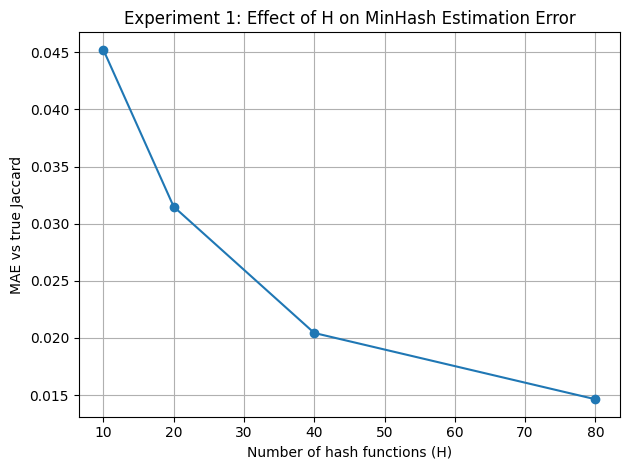


--- Experiment Results ---
{10: {'mae': np.float64(0.0452119877233351), 'rmse': np.float64(0.05605904996256189), 'corr': np.float64(0.16568479521245927)}, 20: {'mae': np.float64(0.03149054297706361), 'rmse': np.float64(0.037269446692931585), 'corr': np.float64(0.20423866885816955)}, 40: {'mae': np.float64(0.02043848867829231), 'rmse': np.float64(0.025767684170987418), 'corr': np.float64(0.264011069268113)}, 80: {'mae': np.float64(0.014639085165420795), 'rmse': np.float64(0.018371195009488625), 'corr': np.float64(0.36460559284433697)}}
--------------------------


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import random

def experiment_1_minhash_accuracy(
    shingled_data,
    true_jaccard_lookup=None,
    num_hashes_list=(10, 20, 40, 80, 120, 160, 200),
    max_pairs=None,
    seed=42,
    save_plot_path="exp1_numhash_vs_error.png"):
    """
    输入:
      shingled_data       : [(docid, [items]), ...]（items 建议去重）
      true_jaccard_lookup : 可选，dict[(id1,id2)] = 真实 Jaccard（若为空则现场计算）
      num_hashes_list     : 需要测试的哈希函数个数列表
      max_pairs           : 可选，若文档很多，可随机抽样若干对计算，控制时间
      seed                : 随机种子（用于抽样与哈希）
      save_plot_path      : 图片保存路径
    输出:
      results: {H: {"mae": 平均绝对误差, "rmse": 均方根误差, "corr": 相关系数}}，并画图（H vs MAE）
    """
    rng = random.Random(seed)

    # 文档 id 列表与所有对
    docids = [docid for docid, _ in shingled_data]
    pairs = []
    for i in range(len(docids)):
        for j in range(i + 1, len(docids)):
            pairs.append((docids[i], docids[j]))

    # 抽样
    if max_pairs is not None and max_pairs < len(pairs):
        print(f"Sampling {max_pairs} pairs from {len(pairs)} total pairs.")
        pairs = rng.sample(pairs, max_pairs)
    else:
        print(f"Using all {len(pairs)} pairs.")


    # 若未提供真实 Jaccard，则现场计算一次
    if true_jaccard_lookup is None:
        print("Calculating true Jaccard similarities...")
        id2items = {docid: set(items) for docid, items in shingled_data}
        true_jaccard_lookup = {}
        for id1, id2 in pairs:
            # 确保 jaccard 函数已经定义
            s = jaccard(id2items[id1], id2items[id2])
            true_jaccard_lookup[(id1, id2)] = s
        print("Done calculating true Jaccard.")

    results = {}
    # 逐个 H 做 MinHash，并评估误差
    for H in num_hashes_list:
        print(f"Running experiment for H = {H}...")
        # 确保 make_minhash_signature 和 minhash_similarity 函数已经定义
        sig, dlist = make_minhash_signature(shingled_data, H, seed=seed)
        col_index = {d: j for j, d in enumerate(dlist)}

        est_vals = []
        true_vals = []

        for id1, id2 in pairs:
            if id1 not in col_index or id2 not in col_index:
                continue
            est = minhash_similarity(id1, id2, sig, dlist)
            true = true_jaccard_lookup[(id1, id2)]
            est_vals.append(est)
            true_vals.append(true)

        est_arr = np.array(est_vals, dtype=float)
        true_arr = np.array(true_vals, dtype=float)
        if len(est_arr) == 0:
            mae = np.nan
            rmse = np.nan
            corr = np.nan
        else:
            mae = np.mean(np.abs(est_arr - true_arr))
            rmse = np.sqrt(np.mean((est_arr - true_arr) ** 2))
            # 皮尔逊相关
            if np.std(est_arr) == 0 or np.std(true_arr) == 0:
                corr = np.nan
            else:
                corr = np.corrcoef(est_arr, true_arr)[0, 1]

        results[H] = {"mae": mae, "rmse": rmse, "corr": corr}
        print(f"H={H}: MAE={mae:.4f}, RMSE={rmse:.4f}, Corr={corr:.4f}")

    # 画图：H vs MAE
    Hs = sorted(results.keys())
    maes = [results[h]["mae"] for h in Hs]

    plt.figure()
    plt.plot(Hs, maes, marker="o")
    plt.xlabel("Number of hash functions (H)")
    plt.ylabel("MAE vs true Jaccard")
    plt.title("Experiment 1: Effect of H on MinHash Estimation Error")
    plt.grid(True) # 增加网格线
    plt.tight_layout()
    plt.savefig(save_plot_path, dpi=200)
    print(f"\nPlot saved to {save_plot_path}")
    plt.show()
    plt.close()

    return results, save_plot_path

# --- 调用实验 ---

# 修正：使用你指定的 1000 篇文档的路径
data_path = "/content/sample_data/MinHash/data/articles_1000.train"
# data_path = "/content/sample_data/mnist_train_small.csv"
k = 5  # 选一个合适的 k

print("Parsing data...")
docs = parse_data(data_path)  # [(id, processed_text)]

print("Shingling documents...")
shingled_data = [(docid, list(set(shingle_document(text, k)))) for docid, text in docs]

# 跑实验：测试多种哈希个数
num_hashes_list = [10, 20, 40, 80]

# 1000 篇文档总共有 (1000 * 999) / 2 = 499,500 对
# max_pairs=50000 是一个合理的抽样数量
print("Starting Experiment 1...")
results, fig_path = experiment_1_minhash_accuracy(
    shingled_data,
    num_hashes_list=num_hashes_list,
    max_pairs=50000  # 限制比较的文档对数量，加快速度
)

print("\n--- Experiment Results ---")
print(results)
print("--------------------------")

## 4. Part III: Locality-Sensitive Hashing
**DUE**: Tuesday Sept. 25

### 4.1 Implement LSH (Text)
Write a function that implements locality sensitive hashing. Function specifications:
- Input:
  1. `minhash_sigmatrix`: A minhash signature matrix.
  2. `numhashes`: Number of hash functions used to construct the minhash signature matrix.
  3. `docids`: List of document ids.
  4. `threshold`: A minimum Jaccard similarity threshold.
- Output: A list of hash tables.

In [14]:
from collections import defaultdict
import numpy as np
import random
import matplotlib.pyplot as plt

def choose_nbands(t, H):
    """
    为给定的 Jaccard 阈值 t 和哈希函数数量 H，选择最佳的 b (bands) 和 r (rows)。
    这会找到一个 b，使得 (1/b)^(1/r) ≈ t
    """
    best_b = 1
    min_err = 1.0
    for b_test in range(1, H + 1):
        if H % b_test == 0:
            r_test = H // b_test
            # LSH 的 S-curve 近似阈值
            t_approx = (1.0 / b_test)**(1.0 / r_test)
            err = abs(t_approx - t)
            if err < min_err:
                min_err = err
                best_b = b_test

    best_r = H // best_b
    print(f"  [LSH Setup] Threshold t={t:.2f} -> b={best_b}, r={best_r}")
    return best_b, best_r

def _make_vector_hash(r):
    """
    返回一个函数，该函数将长度为 r 的向量哈希到一个整数
    """
    # 为简单起见，我们只使用 Python 内置的 hash()
    # 将 numpy 向量转换为 bytes 可以获得一个稳定的哈希值
    def hash_func(v):
        return hash(v.tobytes())
    return hash_func

def do_lsh(minhash_sigmatrix, numhashes, docids, threshold):
  """
  4.1 实现 LSH
  """
  # choose the number of bands, and rows per band to use in LSH
  b, _ = choose_nbands(threshold, numhashes)
  r = int(numhashes / b)

  narticles = len(docids)

  # generate a random hash function that takes vectors of length r as input
  # 注意：在我们的实现中，_make_vector_hash 不依赖 r
  hash_func = _make_vector_hash(r)

  # setup the list of hashtables, will be populated with one hashtable per band
  buckets = []

  # fill hash tables for each band
  for band in range(b):
    # figure out which rows of minhash signature matrix to hash for this band
    start_index = int(band * r)
    end_index = min(start_index + r, numhashes)

    # initialize hashtable for this band
    cur_buckets = defaultdict(list)

    for j in range(narticles):
      # --- 这是你需要实现的部分 (BEGIN) ---

      # 1. 获取当前文档 j 在当前 band 的签名向量
      vector_slice = minhash_sigmatrix[start_index:end_index, j]

      # 2. 哈希这个向量，得到 bucket ID
      bucket_id = hash_func(vector_slice)

      # 3. 将真实的 docid（而不是列索引 j）放入桶中
      doc_id = docids[j]
      cur_buckets[bucket_id].append(doc_id)

      # --- 这是你需要实现的部分 (END) ---

    # add this hashtable to the list of hashtables
    buckets.append(cur_buckets)

  return buckets

### 4.2 Find candidate similar article pairs (Text)
Write a function that uses the result of your LSH function and returns a list of candidate article pairs. Specifications:
- Input: The result of `do_lsh`.
- Output: A list of tuples `(docid1, docid2)`, each being a candidate similar article pair according to LSH.

In [15]:
def find_candidate_pairs(buckets):
    candidate_pairs = set()

    for table in buckets:
        # 遍历该 band 的所有桶
        for doc_list in table.values():
            # 如果桶里有超过1个文档，它们就是候选对
            if len(doc_list) > 1:
                # 生成桶内所有唯一的文档对
                for i in range(len(doc_list)):
                    for j in range(i + 1, len(doc_list)):
                        id1 = doc_list[i]
                        id2 = doc_list[j]

                        # 按顺序存储，(id1, id2) 和 (id2, id1) 视为相同
                        if id1 < id2:
                            pair = (id1, id2)
                        else:
                            pair = (id2, id1)

                        candidate_pairs.add(pair)

    return candidate_pairs

### 4.3 Experiment 2: LSH sensitivity (Text)
Use these functions to compute the sensitivity and specificity of LSH as a function of the threshold. Use the 10,000-document dataset to perform this experiment.

Parsing 10k data...
Shingling 10k documents...
Creating MinHash Signatures (H=10)...
MinHash Signatures complete.
--- Starting Experiment 2 ---
Using 10 hash functions.
Sampling 100000 pairs to create ground truth...
Ground truth calculated for 100000 pairs.

Processing LSH for threshold t = 0.3...
  [LSH Setup] Threshold t=0.30 -> b=5, r=2
  Found 399148 candidate pairs.
  Sensitivity: nan (Found 0 of 0)
  Specificity: 0.9959 (Ignored 99594 of 100000)

Processing LSH for threshold t = 0.4...
  [LSH Setup] Threshold t=0.40 -> b=5, r=2
  Found 399148 candidate pairs.
  Sensitivity: nan (Found 0 of 0)
  Specificity: 0.9959 (Ignored 99594 of 100000)

Processing LSH for threshold t = 0.5...
  [LSH Setup] Threshold t=0.50 -> b=5, r=2
  Found 399148 candidate pairs.
  Sensitivity: nan (Found 0 of 0)
  Specificity: 0.9959 (Ignored 99594 of 100000)

Processing LSH for threshold t = 0.6...
  [LSH Setup] Threshold t=0.60 -> b=5, r=2
  Found 399148 candidate pairs.
  Sensitivity: nan (Found 0 of 

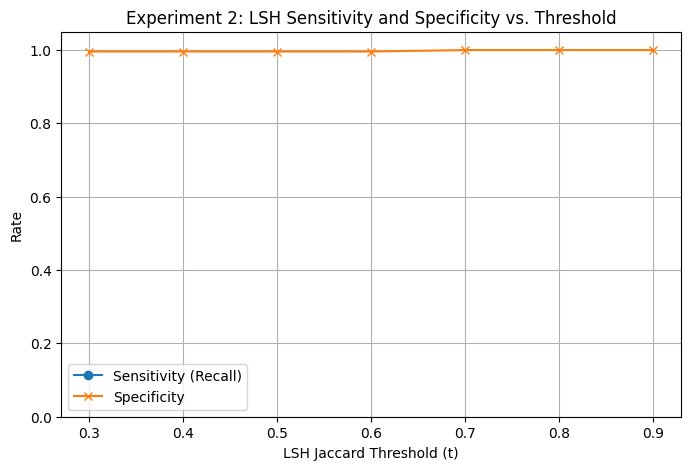


--- Experiment 2 Results ---
t=0.3: Sensitivity=nan, Specificity=0.9959
t=0.4: Sensitivity=nan, Specificity=0.9959
t=0.5: Sensitivity=nan, Specificity=0.9959
t=0.6: Sensitivity=nan, Specificity=0.9959
t=0.7: Sensitivity=nan, Specificity=1.0000
t=0.8: Sensitivity=nan, Specificity=1.0000
t=0.9: Sensitivity=nan, Specificity=1.0000
Plot saved to: exp2_lsh_sensitivity.png


In [17]:
def experiment_2_lsh_sensitivity(
    shingled_data,
    sigmatrix,
    docids,
    num_hashes,
    threshold_list=(0.3, 0.5, 0.7, 0.8, 0.9),
    max_pairs=100000,
    seed=42
):
    """
    4.3 运行实验 2
    """
    print(f"--- Starting Experiment 2 ---")
    print(f"Using {num_hashes} hash functions.")

    rng = random.Random(seed)

    # --- 1 & 2. 抽样并计算真实 Jaccard (我们的测试集) ---
    print(f"Sampling {max_pairs} pairs to create ground truth...")

    all_pairs = []
    for i in range(len(docids)):
        for j in range(i + 1, len(docids)):
            all_pairs.append((docids[i], docids[j]))

    if len(all_pairs) > max_pairs:
        sampled_pairs = rng.sample(all_pairs, max_pairs)
    else:
        sampled_pairs = all_pairs
        print(f"Warning: max_pairs > total pairs. Using all {len(all_pairs)} pairs.")

    # 存储真实 Jaccard 相似度
    id2items = {docid: set(items) for docid, items in shingled_data}
    true_jaccard_lookup = {}
    for id1, id2 in sampled_pairs:
        # 假设 jaccard() 函数已定义
        s = jaccard(id2items[id1], id2items[id2])
        true_jaccard_lookup[(id1, id2)] = s

    print(f"Ground truth calculated for {len(true_jaccard_lookup)} pairs.")

    # --- 3 & 4. 遍历 LSH 阈值 ---
    results = {}

    for t in threshold_list:
        print(f"\nProcessing LSH for threshold t = {t}...")

        # 4b. 运行 LSH
        buckets = do_lsh(sigmatrix, num_hashes, docids, t)
        lsh_candidates = find_candidate_pairs(buckets)
        print(f"  Found {len(lsh_candidates)} candidate pairs.")

        # 4c. 计算 TP, FP, TN, FN
        TP, FP, TN, FN = 0, 0, 0, 0

        for pair, true_jaccard in true_jaccard_lookup.items():

            is_truly_similar = (true_jaccard >= t)
            is_lsh_candidate = (pair in lsh_candidates)

            if is_truly_similar and is_lsh_candidate:
                TP += 1
            elif is_truly_similar and not is_lsh_candidate:
                FN += 1
            elif not is_truly_similar and is_lsh_candidate:
                FP += 1
            elif not is_truly_similar and not is_lsh_candidate:
                TN += 1

        # 4d. 计算指标
        total_positives = TP + FN
        total_negatives = TN + FP

        sensitivity = (TP / total_positives) if total_positives > 0 else np.nan
        specificity = (TN / total_negatives) if total_negatives > 0 else np.nan

        results[t] = {
            "sensitivity": sensitivity,
            "specificity": specificity,
            "TP": TP, "FN": FN, "TN": TN, "FP": FP
        }
        print(f"  Sensitivity: {sensitivity:.4f} (Found {TP} of {total_positives})")
        print(f"  Specificity: {specificity:.4f} (Ignored {TN} of {total_negatives})")

    # --- 5. 绘图 ---
    ts = sorted(results.keys())
    sens = [results[t]["sensitivity"] for t in ts]
    spec = [results[t]["specificity"] for t in ts]

    plt.figure(figsize=(8, 5))
    plt.plot(ts, sens, marker='o', label='Sensitivity (Recall)')
    plt.plot(ts, spec, marker='x', label='Specificity')
    plt.xlabel("LSH Jaccard Threshold (t)")
    plt.ylabel("Rate")
    plt.title("Experiment 2: LSH Sensitivity and Specificity vs. Threshold")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05)

    fig_path = "exp2_lsh_sensitivity.png"
    plt.savefig(fig_path, dpi=200)
    plt.show()
    plt.close()

    return results, fig_path

# --- 1. 加载和 Shingle 数据 ---
# 使用 10000 篇文档的数据集
data_path_10k = "/content/sample_data/MinHash/data/articles_10000.train"
k = 5
H = 10 # 从实验1中选择一个较好的哈希数
SEED = 42

print("Parsing 10k data...")
docs_10k = parse_data(data_path_10k)

print("Shingling 10k documents...")
shingled_data_10k = [(docid, list(set(shingle_document(text, k)))) for docid, text in docs_10k]

# --- 2. 生成 MinHash 签名 (只做一次) ---
print(f"Creating MinHash Signatures (H={H})...")
sigmatrix_10k, docids_10k = make_minhash_signature(shingled_data_10k, H, seed=SEED)
print("MinHash Signatures complete.")

# --- 3. 运行实验 2 ---
# 测试的阈值列表
threshold_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 抽样 10 万对来计算真实 Jaccard
exp2_results, exp2_fig_path = experiment_2_lsh_sensitivity(
    shingled_data_10k,
    sigmatrix_10k,
    docids_10k,
    num_hashes=H,
    threshold_list=threshold_list,
    max_pairs=100000,
    seed=SEED
)

print("\n--- Experiment 2 Results ---")
for t, res in exp2_results.items():
    print(f"t={t:.1f}: Sensitivity={res['sensitivity']:.4f}, Specificity={res['specificity']:.4f}")
print(f"Plot saved to: {exp2_fig_path}")

## 5. Helpers

### 5.1 Obtaining data (Text)
You can use the following Python code to download data for the project.

In [18]:
import os
from six.moves import urllib
import random
import numpy as np
import scipy.optimize as opt
import math
from typing import List, Callable, Any

## 5.1 获取数据 (Data Fetching)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/chrisjmccormick/MinHash/master/data"
PLAGIARISM_PATH = "datasets/plagiarism"
DATA_SIZES = [100, 1000, 2500, 10000]

def fetch_data(download_root=DOWNLOAD_ROOT,
               plagiarism_path=PLAGIARISM_PATH,
               data_sizes=DATA_SIZES,
               maxsize=1000):
  """
  下载指定大小的数据集文件。
  """
  if not os.path.isdir(plagiarism_path):
      os.makedirs(plagiarism_path)
  for size in data_sizes:
      if size <= maxsize:
          print(f"Fetching data for size {size}...")
          train_file = "articles_" + str(size) + ".train"
          train_path = os.path.join(plagiarism_path, train_file)
          if not os.path.exists(train_path):
              train_url = download_root + '/' + train_file
              print(f"Downloading {train_url} to {train_path}")
              urllib.request.urlretrieve(train_url, train_path)
          else:
              print(f"File {train_path} already exists.")

          truth_file = "articles_" + str(size) + ".truth"
          truth_path = os.path.join(plagiarism_path, truth_file)
          if not os.path.exists(truth_path):
              truth_url = download_root + "/" + truth_file
              print(f"Downloading {truth_url} to {truth_path}")
              urllib.request.urlretrieve(truth_url, truth_path)
          else:
              print(f"File {truth_path} already exists.")
  print("Data fetching complete.")

**Usage Instructions** (Text):
The `fetch_data` function will download data to the subdirectory pointed to by `PLAGIARISM_PATH`. You can assign the path where you want to store your data to this variable.
The `maxsize` parameter is used to limit the size of the downloaded data. For testing and development, it is recommended to use the 1000-document dataset, which can be obtained by calling `fetch_data(maxsize=1000)`.

### 5.2 Generating random hash functions (Text)
This function generates a random hash function suitable for mimicking permutations over 32-bit integers. Recall that since we are using `crc32` to represent items, we need random hash functions that generate 32-bit numbers.

In [19]:
import random

def make_random_hash_fn(p=2**33-355, m=4294967295):
    a = random.randint(1,p-1)
    b = random.randint(0, p-1)
    return lambda x: ((a * x + b) % p) % m

**Usage Example** (Text):

In [20]:
hash_fn = make_random_hash_fn()
hash_fn(12345)

2855519481

**Explanation** (Text):
This implements a universal hash function for 32-bit integers, which ensures that the result corresponds to the permutation of rows of the characteristic matrix required by Minhash (Refer to: [https://en.wikipedia.org/wiki/Universal_hashing](https://en.wikipedia.org/wiki/Universal_hashing)). Here, `m` is the largest number returned by `crc32`, and `p` is a prime number larger than `m`.

### 5.3 Comparing numpy vectors (Text)
The following code snippet shows how to use numpy to compare two integer vectors, which is required to compute the minhash similarity estimate.

In [21]:
# generate two vectors of length 50 with random integers from 0 to 100
a = np.random.randint(100, size=50)
b = np.random.randint(100, size=50)

# compute the fraction of entries in which two vectors are equal
np.mean(a == b)

np.float64(0.04)

### 5.4 Choosing the number of bands for LSH (Text)
Given a similarity threshold, we need to choose the number of bands to use in LSH. You can use the following function to do this.

In [22]:
import scipy.optimize as opt
import math

def _choose_nbands(t, n):
    def _error_fun(x):
        cur_t = (1/x[0])**(x[0]/n)
        return (t-cur_t)**2

    opt_res = opt.minimize(error_fun, x0=(10), method='Nelder-Mead')
    b = int(math.ceil(res['x'][0]))
    r = int(n / b)
    final_t = (1/b)**(1/r)
    return b, final_t

### 5.5 Hashing a vector (Text)
In LSH, we need to hash the `r` hash values of each document for each band. You can use the following function to generate a hash function for vectors.

In [23]:
def _make_vector_hash(num_hashes, m=4294967295):
    hash_fns = make_hashes(num_hashes)
    def _f(vec):
      acc = 0
      for i in range(len(vec)):
        h = hash_fns[i]
        acc += h(vec[i])
      return acc % m
    return _f